In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display

%matplotlib inline

C:\Users\yu\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#Full Time Result (H=Home Win, D=Draw, A=Away Win)
#HTGD - Home team goal difference
#ATGD - away team goal difference
#HTP - Home team points
#ATP - Away team points
#DiffFormPts Diff in points
#DiffLP - Differnece in last years prediction

In [3]:
# Read data and drop redundant column.
data = pd.read_csv('final_dataset.csv')

# Remove first 3 matchweeks
data = data[data.MW > 3]

data.drop(['Unnamed: 0','HomeTeam', 'AwayTeam', 'Date', 'MW', 'HTFormPtsStr', 'ATFormPtsStr', 'FTHG', 'FTAG',
           'HTGS', 'ATGS', 'HTGC', 'ATGC','HomeTeamLP', 'AwayTeamLP','DiffPts','HTFormPts','ATFormPts',
           'HM4','HM5','AM4','AM5','HTLossStreak5','ATLossStreak5','HTWinStreak5','ATWinStreak5',
           'HTWinStreak3','HTLossStreak3','ATWinStreak3','ATLossStreak3'],1, inplace=True)
data.head()
data.isna()

,FTR,HTP,ATP,HM1,HM2,HM3,AM1,AM2,AM3,HTGD,ATGD,DiffFormPts,DiffLP
30,False,False,False,False,False,False,False,False,False,False,False,False,False
31,False,False,False,False,False,False,False,False,False,False,False,False,False
32,False,False,False,False,False,False,False,False,False,False,False,False,False
33,False,False,False,False,False,False,False,False,False,False,False,False,False
34,False,False,False,False,False,False,False,False,False,False,False,False,False
35,False,False,False,False,False,False,False,False,False,False,False,False,False
36,False,False,False,False,False,False,False,False,False,False,False,False,False
37,False,False,False,False,False,False,False,False,False,False,False,False,False
38,False,False,False,False,False,False,False,False,False,False,False,False,False
39,False,False,False,False,False,False,False,False,False,False,False,False,False


## Exploring Data

In [4]:
n_matches = data.shape[0]       # Total number of  matches
n_features = data.shape[1] - 1  # number of features
n_homewins = len(data[data.FTR == 'H']) # HT matches won 
win_rate = (float(n_homewins) / (n_matches)) * 100  # HT win rate

# Print the results
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Number of matches won by home team: {}".format(n_homewins))
print ("Win rate of home team: {:.2f}%".format(win_rate))

Total number of matches: 6300
Number of features: 12
Number of matches won by home team: 2939
Win rate of home team: 46.65%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A4B22E8668>,
      dtype=object)

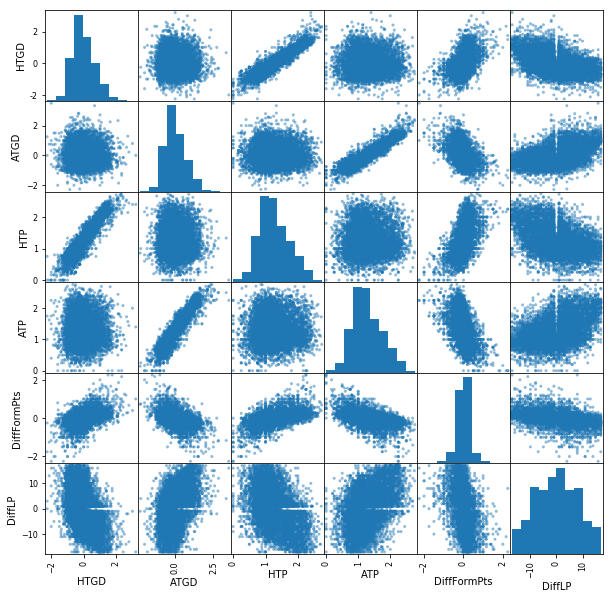

In [5]:
# Visualising distribution/correlation of data
from pandas.plotting import scatter_matrix

scatter_matrix(data[['HTGD','ATGD','HTP','ATP','DiffFormPts','DiffLP']], figsize=(10,10))

## Data Preprocessing

In [6]:
# Separate into feature and target variable (X,y)
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardization
from sklearn.preprocessing import scale
cols = [['HTGD','ATGD','HTP','ATP','DiffLP']]
for col in cols:
    X_all[col] = scale(X_all[col])

Then Convert/Preprocess the Categorial Feature into Binary Data Type

In [7]:
# Last 3 Game on both sides
X_all.HM1 = X_all.HM1.astype('str')
X_all.HM2 = X_all.HM2.astype('str')
X_all.HM3 = X_all.HM3.astype('str')
X_all.AM1 = X_all.AM1.astype('str')
X_all.AM2 = X_all.AM2.astype('str')
X_all.AM3 = X_all.AM3.astype('str')

def preprocess_features(X):
    
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical -> convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Revised
        output = output.join(col_data)
    
    return output
 
X_all = preprocess_features(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (24 total features):
['HTP', 'ATP', 'HM1_D', 'HM1_L', 'HM1_W', 'HM2_D', 'HM2_L', 'HM2_W', 'HM3_D', 'HM3_L', 'HM3_W', 'AM1_D', 'AM1_L', 'AM1_W', 'AM2_D', 'AM2_L', 'AM2_W', 'AM3_D', 'AM3_L', 'AM3_W', 'HTGD', 'ATGD', 'DiffFormPts', 'DiffLP']


In [8]:
from sklearn.model_selection import train_test_split

# split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 380,
                                                    random_state = 2,
                                                    stratify = y_all)

## Training and Evaluating Models

Import some kind of training functions (F1)

In [9]:
from time import time 
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label='H'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [10]:
## Initialize the three models (XGBoost is initialized later)
clf_A = LogisticRegression(random_state = 42)
clf_B = SVC(random_state = 912, kernel='rbf')
clf_C = xgb.XGBClassifier(seed = 82)

train_predict(clf_A, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ('')

Training a LogisticRegression using a training set size of 5920. . .
Trained model in 0.0468 seconds
Made predictions in 0.0030 seconds.
0.6191926884996192 0.6621621621621622
F1 score and accuracy score for training set: 0.6192 , 0.6622.
Made predictions in 0.0010 seconds.
F1 score and accuracy score for test set: 0.6836 , 0.7053.

Training a SVC using a training set size of 5920. . .
Trained model in 1.4797 seconds
Made predictions in 0.7911 seconds.
0.6111222646055009 0.6728040540540541
F1 score and accuracy score for training set: 0.6111 , 0.6728.
Made predictions in 0.0510 seconds.
F1 score and accuracy score for test set: 0.6393 , 0.6763.

Training a XGBClassifier using a training set size of 5920. . .
Trained model in 0.3738 seconds
Made predictions in 0.0200 seconds.
0.6445736434108527 0.6902027027027027
F1 score and accuracy score for training set: 0.6446 , 0.6902.
Made predictions in 0.0030 seconds.
F1 score and accuracy score for test set: 0.6744 , 0.7053.



C:\Users\yu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\yu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Hyper Parameter Optimization

In [11]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# Initialize Hyper Parameter
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [40],
               'max_depth': [3],
               'min_child_weight': [3],
               'gamma':[0.4],
               'subsample' : [0.8],
               'colsample_bytree' : [0.8],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# Initialize the classifier
clf = xgb.XGBClassifier(seed=2)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label='H')

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)
# Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)
# Get the estimator
clf = grid_obj.best_estimator_
print (clf)
# Report the final F1 score for training and testing after parameter tuning
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

C:\Users\yu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\yu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\yu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\yu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=3, missing=None,
       n_estimators=40, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=2, silent=True,
       subsample=0.8)
Made predictions in 0.0090 seconds.
F1 score and accuracy score for training set: 0.6258 , 0.6782.
Made predictions in 0.0020 seconds.
F1 score and accuracy score for test set: 0.6388 , 0.6816.


C:\Users\yu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\yu\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Prediction